In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import statsmodels as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.api import ARIMA

import pmdarima as pm

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## KEY CONCEPTS

1. `Autocorrelation`
* What is the difference between correlation and autocorrelation? => autocorrelation is analogous to correlation, but instead of describing the relationship between 2 different variables, it describes a relationship between a variable and lagged values of that variable instead. (2 variables from a same time series, auto = self)

2. `ACF plot`, `PACF plot`
* The ACF plot reflects both the direct and indirect interplays between the lags in the Time Series. It is useful to identify the optimal order of the pure AR model.
* The PACF plot, which controls the indirect effects, is useful to identify the order of the pure MA model.
* When combining the AR and MA model, the effects are mixed, hence more difficult to identify using ACF/PACF plots.

3. `Stationarity`
* The weak-sense definition of stationarity is covariance stationarity: the 1st and 2nd moments, as well as the ACF of the Time Series remain stable. The models are less useful for future predictions if these parameters are dynamic.

4. `Differencing`
* This is one of the common technique to make the Time Series stationary.

5. `ARIMA`
* ARIMA = ARMA + Differencing.
* Integration (I):\
a) The "Integrated" part of ARIMA handles non-stationary data by differencing.\
b) Differencing involves subtracting the previous value from the current value.\
c) This process removes trends and makes the series stationary.

* ARIMA(p, d, q):\
a) p: Order of the AR part.\
b) d: Order of differencing required to make the series stationary.\
c) q: Order of the MA part.

* Special cases:\
a) ARIMA(p, 0, 0) = AR(p) / ARMA (p, 0): Pure autoregressive model.\
b) ARIMA(0, 0, q) = MA(q) / ARMA (0, q): Pure moving average model.\
c) ARIMA(0, d, 0) = I(d): Purely differenced series, like a random walk.

* Random walk: ARIMA(0, 1, 0) and I(1) is the random walk.

6. `SARIMA`
* Stock prices don’t typically have seasonality, but stock prices don’t comprise all financial data. e.g. weather (seasons) affect real estate purchase.
* ARIMA with the “I” component can handle trends by differencing, but it doesn’t handle seasonality well on its own, which is why seasonal versions of ARIMA (SARIMA) are used for time series with strong seasonal components.
* SARIMA includes both non-seasonal and seasonal components.
* The model is typically denoted with 6 parameters in total: SARIMA{(p, d, q) *  (P, D, Q)[m]}, where:
> p: Non-seasonal autoregressive order (AR).\
> d: Non-seasonal differencing order (I).\
> q: Non-seasonal moving average order (MA).\
> P: Seasonal autoregressive order (SAR).\
> D: Seasonal differencing order (seasonal I).\
> Q: Seasonal moving average order (SMA).\
> m: The number of time periods per season (e.g., 12 for monthly data with yearly seasonality).

* This implies that the SARIMA model is the multiplication of the non-seasonal and the seasonal components. (P, D, Q)m is the pure seasonal ARIMA model where m is seasonal frequency requires D seasonal differencing, has P AR terms at seasonal lags and Q MA terms at seasonal lags.

* ARIMA can still give a decent forecast without including the seasonaility, but using SARIMA can lead to a better model.

### <b>1. Manual implementation of ARIMA<b>

In [4]:
df1 = pd.read_csv('airline_passengers.csv', index_col =  'Month', parse_dates = True)
df1.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


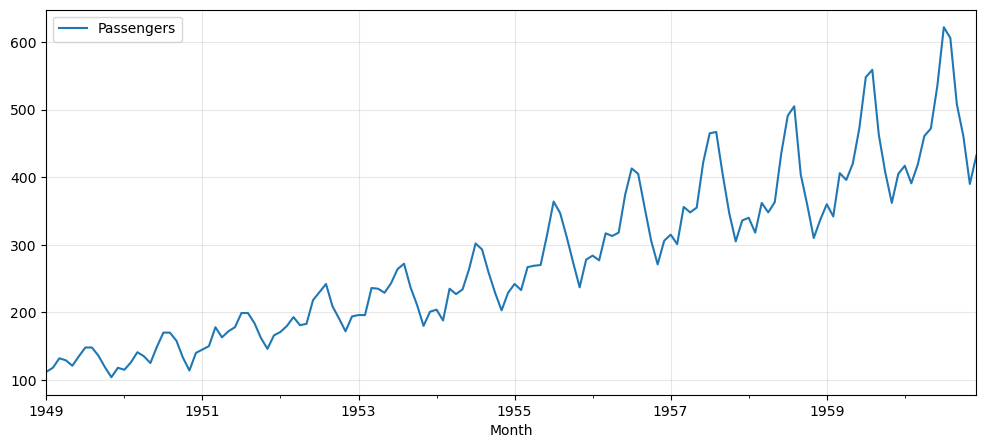

In [5]:
df1.plot(figsize = (12, 5))
plt.grid(True, alpha = 0.3);

#### 1.1. Check for Trends, Non-zero means and find an optimal Integration order

In [7]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

def check_stationarity(series):
    result = {}

    # ADF test for stationarity (null hypothesis: series has a unit root, i.e., non-stationary)
    adf_test = adfuller(series.dropna())  # Dropping missing values if any
    adf_stat, adf_pvalue = adf_test[0], adf_test[1]
    
    if adf_pvalue < 0.05:
        result['ADF Test'] = "The series is stationary (p-value < 0.05)"
    else:
        result['ADF Test'] = "The series is non-stationary (p-value >= 0.05)"

    # KPSS test for stationarity (null hypothesis: series is stationary)
    kpss_test = kpss(series.dropna(), regression='ct')  # 'ct' for constant and trend
    kpss_stat, kpss_pvalue = kpss_test[0], kpss_test[1]
    
    if kpss_pvalue < 0.05:
        result['KPSS Test'] = "The series has a trend or is non-stationary (p-value < 0.05)"
    else:
        result['KPSS Test'] = "The series is stationary (p-value >= 0.05)"
    
    # KPSS test for constant (non-zero mean)
    kpss_const_test = kpss(series.dropna(), regression='c')  # 'c' for constant only
    kpss_const_pvalue = kpss_const_test[1]
    
    if kpss_const_pvalue < 0.05:
        result['KPSS Constant'] = "The series has a non-zero mean (constant)"
    else:
        result['KPSS Constant'] = "The series has no significant constant (zero mean)"

    return result

In [8]:
check_stationarity(df1.Passengers)

{'ADF Test': 'The series is non-stationary (p-value >= 0.05)',
 'KPSS Test': 'The series is stationary (p-value >= 0.05)',
 'KPSS Constant': 'The series has a non-zero mean (constant)'}

* From KPSS test, we see this series has a drift term that results in a trending movement.
* From the ADF test, this series is non-stationary.
* So we need to apply Differencing.
* Let's def another one to check the proper differencing order.

In [10]:
def difference_until_pass_kpss(time_series, max_diff=3, significance_level=0.05):
    """
    Perform differencing on the time series until it passes the KPSS test for stationarity
    or until the maximum number of differencing steps (max_diff) is reached.

    Parameters:
    - time_series: The original time series (pandas Series).
    - max_diff: The maximum number of differencing steps to apply.
    - significance_level: The significance level for the KPSS test (default is 0.05).

    Prints:
    - A message indicating whether the series became stationary or failed the KPSS test.
    """

    # Sub-function to perform the KPSS test
    def kpss_test(ts):
        """Run KPSS test on the time series and return whether it passes the test (stationary)."""
        statistic, p_value, _, _ = kpss(ts, regression='c', nlags="auto")
        return p_value > significance_level  # If p-value is greater than significance level, the series is stationary

    d = 0  # Initialize differencing count
    diff_series = time_series.copy()

    # Loop to difference and test for stationarity using KPSS
    while d <= max_diff:
        if kpss_test(diff_series):
            print(f"Series became stationary after {d} differencing(s).")
            break  # Stop further execution if series is stationary
        else:
            d += 1
            if d <= max_diff:
                diff_series = diff_series.diff().dropna()  # Apply differencing internally

    # If the loop ends without the series becoming stationary
    if d > max_diff:
        print(f"The series fails the KPSS test at d = {max_diff}.")

In [11]:
difference_until_pass_kpss(df1.Passengers)

Series became stationary after 1 differencing(s).


* So d = 1 is a good candidate in the optimal model.
* Let apply Differencing once, and check again.

In [13]:
df1['Passengers_Diff'] = df1.Passengers.diff()

In [14]:
check_stationarity(df1['Passengers_Diff'].dropna())

{'ADF Test': 'The series is non-stationary (p-value >= 0.05)',
 'KPSS Test': 'The series is stationary (p-value >= 0.05)',
 'KPSS Constant': 'The series has no significant constant (zero mean)'}

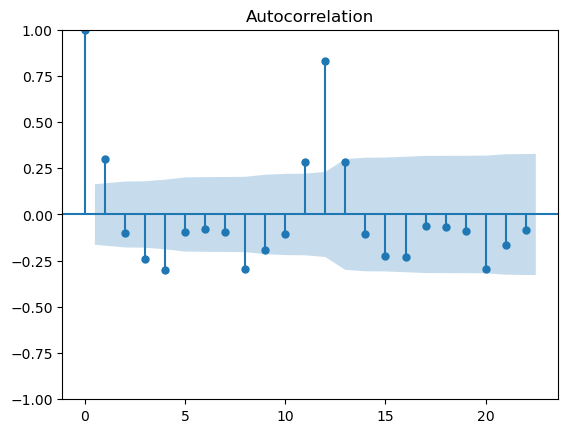

In [15]:
plot_acf(df1['Passengers_Diff'].dropna());

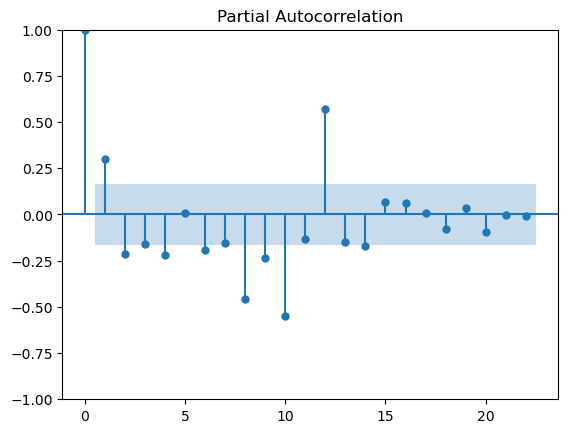

In [16]:
plot_pacf(df1['Passengers_Diff'].dropna());

* Lag 12 is a good candidate to set the orders for AR and MA components.
* Because in theory MA reflects very-short movements, thus we can choose 12 as the order of the AR component.
* Let's def a function to apply ARIMA for future works.

#### 1.2. Run ARIMA(12, 1, 0) with no constants, and ARIMA(12, 0, 0) with constants

In [19]:
def arima_split(df: pd.DataFrame, data_col: str, Ntest: int, freq='MS', 
                order=(0, 0, 0), trend='c', plot=True, y_name='Time Series', 
                summary=False, diagnostic=False):
    """
    Plot the actual, fitted, and forecasted values with confidence intervals.
    
    Args:
        df: DataFrame containing the time series data.
        data_col: Name of the column with the time series data.
        Ntest: Number of future points to be forecasted and separated from the training data.
        order: ARIMA model order (p, d, q).
        trend: Specifies the trend parameter ('n' for no trend, 'c' for constant, 't' for linear trend).
        plot: Boolean indicating whether to plot the results.
        y_name: Specifies the name for plotting (y-axis and title).
        summary: Boolean indicating whether to print the ARIMA model summary.
        diagnostic: Boolean indicating whether to plot model diagnostics.
        
    Returns:
        train_actual: Actual values from the training set.
        train_pred: Fitted values from the ARIMA model on the training set.
        test_actual: Actual values from the test set.
        test_forecast: Forecasted values from the ARIMA model on the test set.
    """
    df.index.freq = freq  # Setting the frequency facilitates accuracy

    # Set up train set and test set
    train = df.iloc[:-Ntest]
    test = df.iloc[-Ntest:]

    # Fit ARIMA model with dynamic trend
    model = ARIMA(train[data_col], order=order, trend=trend)
    arima_result = model.fit()

    # Get fitted values for the train set
    train_prediction = arima_result.predict(start=train.index[0], end=train.index[-1])

    # Forecast the test set values, including confidence intervals
    test_forecast = arima_result.get_forecast(steps=Ntest)
    forecast = test_forecast.predicted_mean  # Extract mean from forecast
    conf_int = test_forecast.conf_int()  # Extract confidence intervals
    lower, upper = conf_int.iloc[:, 0], conf_int.iloc[:, 1]

    if plot:
        # Plot actual, fitted, and forecasted values
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.plot(df.index, df[data_col], label='Actual values', color='orange', alpha=0.5)

        # Plot fitted values
        ax.plot(train.index, train_prediction, color='green', label='Fitted values')

        # Plot forecast and confidence intervals
        ax.plot(test.index, forecast, label='Forecast values', color='blue')
        ax.fill_between(test.index, lower, upper, color='grey', alpha=0.3, label='Confidence Interval')

        ax.set_title(f'ARIMA{order} ({y_name})', color='darkred')
        ax.set_ylabel(y_name)
        ax.legend(loc='best')
        plt.grid(True, alpha=0.3)
        plt.show()

    # Print ARIMA model summary if requested
    if summary:
        print(arima_result.summary())

    # Run diagnostics if requested
    if diagnostic:
        arima_result.plot_diagnostics(figsize=(12, 8))
        plt.tight_layout()
        plt.show()

    # Store actual and forecasted values for both train and test sets
    train_actual = train[data_col]  # Actual values in the training set
    train_pred = train_prediction   # Fitted (predicted) values for the training set
    test_actual = test[data_col]    # Actual values in the test set
    test_forecast = forecast        # Forecasted values for the test set

    # Return train and test values for further evaluation (e.g., to calculate R², etc.)
    return train_actual, train_pred, test_actual, test_forecast

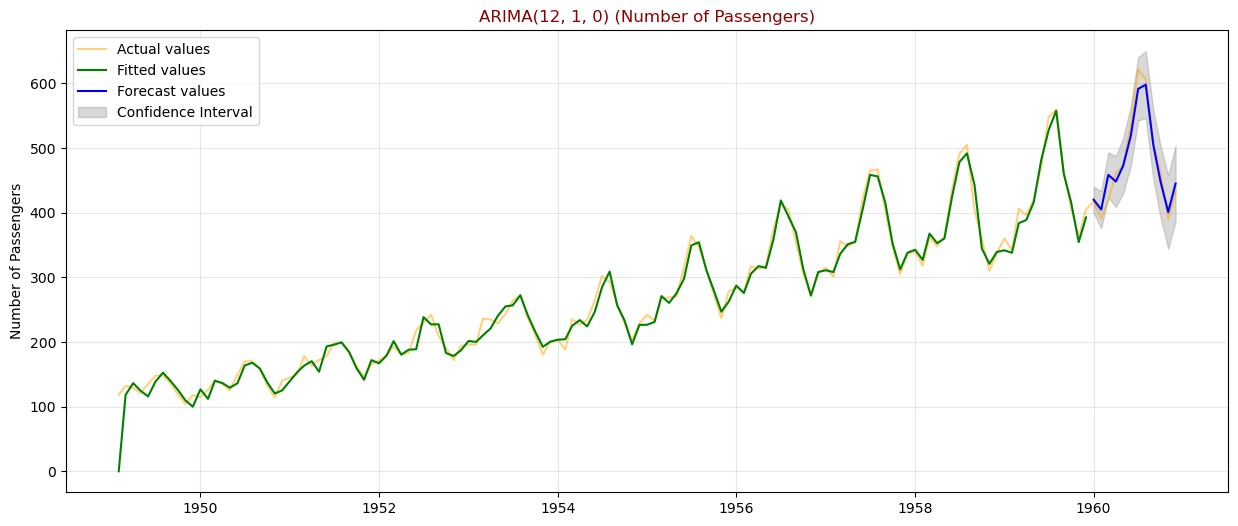

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  131
Model:                ARIMA(12, 1, 0)   Log Likelihood                -499.333
Date:                Sun, 20 Oct 2024   AIC                           1024.667
Time:                        01:12:48   BIC                           1061.945
Sample:                    02-01-1949   HQIC                          1039.814
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0277      0.058      0.476      0.634      -0.086       0.142
ar.L2         -0.0768      0.061     -1.254      0.210      -0.197       0.043
ar.L3         -0.0192      0.048     -0.400      0.6

In [20]:
# ARIMA with I = 1 and constant = 0

train_actual1, train_pred1, test_actual1, test_forecast1 = (
    arima_split(df1.dropna(), 
                'Passengers', Ntest = 12, freq = 'MS', 
                order=(12, 1, 0), 
                plot = True, y_name='Number of Passengers', 
                summary = True, diagnostic = False, trend = 'n')
)

# Ntest = 12 is just an abtrary number for demonstration

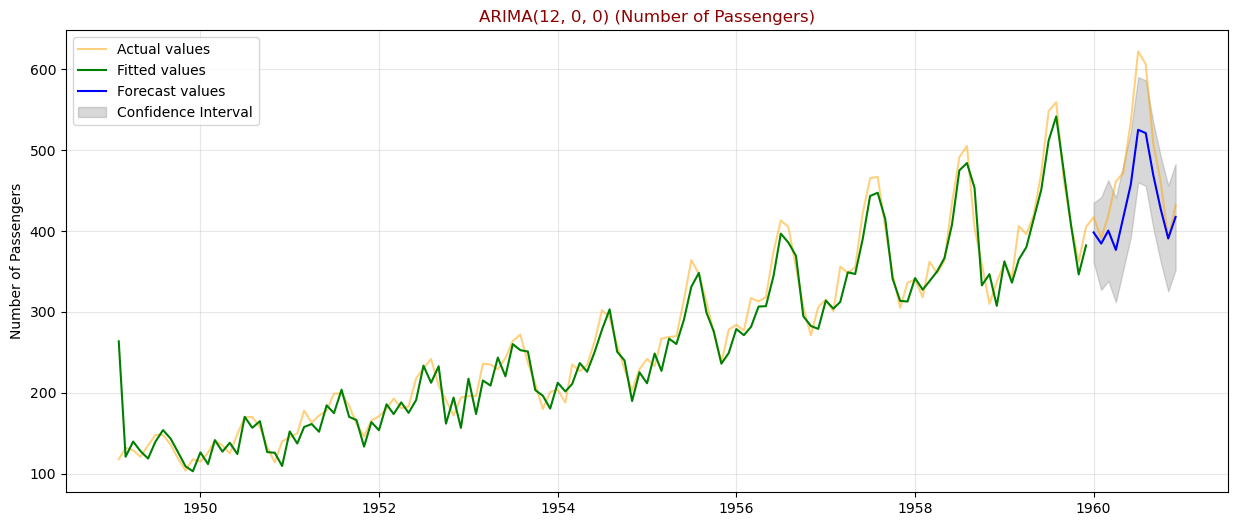

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  131
Model:                ARIMA(12, 0, 0)   Log Likelihood                -573.629
Date:                Sun, 20 Oct 2024   AIC                           1175.258
Time:                        01:12:49   BIC                           1215.510
Sample:                    02-01-1949   HQIC                          1191.614
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        263.6463    201.334      1.309      0.190    -130.962     658.255
ar.L1          1.1974      0.112     10.735      0.000       0.979       1.416
ar.L2         -0.7750      0.143     -5.422      0.0

In [21]:
# ARIMA with I = 0 and constant != 0

train_actual2, train_pred2, test_actual2, test_forecast2 = (
    arima_split(df1.dropna(), 
                'Passengers', Ntest = 12, freq = 'MS', 
                order=(12, 0, 0), 
                plot = True, y_name='Number of Passengers', 
                summary = True, diagnostic = False, trend = 'c')
)

# Ntest = 12 is just an abtrary number for demonstration

* Both models pass the Ljung-Box test.
* For ARIMA, we use AIC as a model selection criteron. The model ARIMA(12, 1, 0) with constant = 0 appears to be better.
* Now let's try performance metrics for more selection.

In [23]:
def evaluate_model(y_true, y_pred, is_logged = False):
    """
    Calculate common metrics to evaluate a model.
    
    Args:
        y_true: Array or list of actual values.
        y_pred: Array or list of predicted values.
        is_logged: if the data has been transformed by log, then reverting back to the original unit
        
    Returns:
        A dictionary with common metrics: MAE, MSE, RMSE, MAPE, R².
    """
    if is_logged == True:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    else:
        y_true =  y_true
        y_pred =  y_pred
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # R-squared (R²)
    r2 = r2_score(y_true, y_pred)
    
    # Return the metrics in a dictionary
    return {
        'MAE': round(mae,6),
        'MSE': round(mse,6),
        'RMSE': round(rmse,6),
        'MAPE': round(mape,6),
        'R²': round(r2, 6) }

In [24]:
print(
    evaluate_model(train_actual1, train_pred1))
print(
    evaluate_model(test_actual1, test_forecast1)
)

{'MAE': 9.345064, 'MSE': 220.687788, 'RMSE': 14.855564, 'MAPE': 4.373756, 'R²': 0.980287}
{'MAE': 13.782375, 'MSE': 306.017228, 'RMSE': 17.493348, 'MAPE': 2.939094, 'R²': 0.944757}


In [25]:
print(
    evaluate_model(train_actual2, train_pred2))
print(
    evaluate_model(test_actual2, test_forecast2)
)

{'MAE': 16.12637, 'MSE': 501.333956, 'RMSE': 22.390488, 'MAPE': 7.144683, 'R²': 0.955217}
{'MAE': 44.327066, 'MSE': 3041.818788, 'RMSE': 55.152686, 'MAPE': 8.622122, 'R²': 0.450883}


* This confirms that the model ARIMA(12, 1, 0) with constant = 0 is better in both in-sample and out-of-sample testting

#### 1.3. Run post-model diagnostic for ARIMA(12, 1, 0)

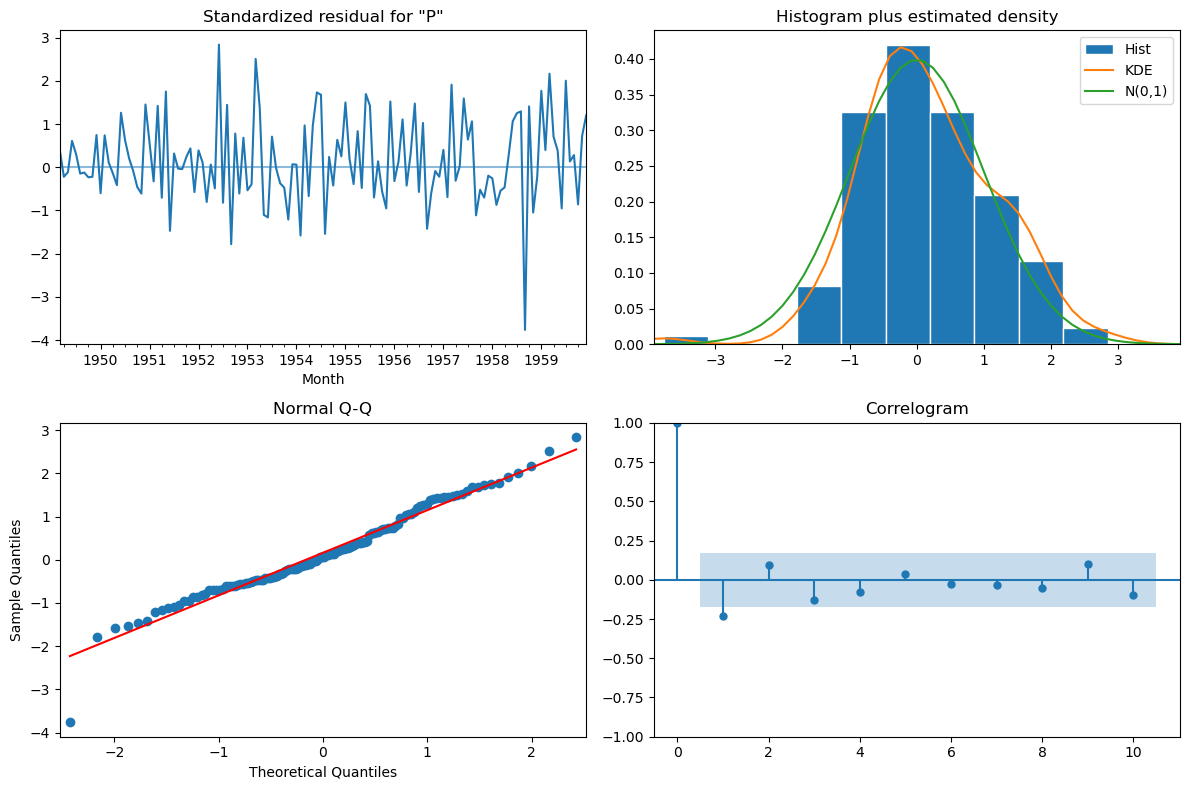

In [28]:
a, b, c, d =  (
    arima_split(df1.dropna(), 
                'Passengers', Ntest = 12, freq = 'MS', 
                order=(12, 1, 0), 
                plot = False, 
                summary = False, diagnostic = True, trend = 'n')
)

<b>`OVERVIEW OF POST-MODEL DIAGNOSTIC REGARDING THE RESIDUALS:`<b>

1. `Standardized Residuals (Top-left)`
* This plot shows the residuals over time, standardized to have a mean of 0 and a standard deviation of 1.
* Interpretation:\
a. The residuals should fluctuate around zero with no clear pattern if the model is well-fitted.\
b. In this plot, the residuals seem to oscillate around zero, but there are some outliers (particularly around 1958–1959), which may indicate that the model isn’t capturing some aspects of the data well, such as extreme values or potential changes in trend.

2. `Histogram plus Estimated Density (Top-right)` and `Q-Q Plot (Bottom-left)`
* These 2 are appproaches to test for Normality of the residuals.
* Interpretation:\
a. KDE: In this case, the histogram roughly matches the normal distribution, but there seems to be some deviation in the tails, especially on the left. This might suggest some skewness or outliers in the residuals.
b. Q-Q Plot: In this plot, most of the points fall along the red line, indicating that the residuals are close to normally distributed. However, there are deviations at the extremes (both left and right), suggesting that there may be some non-normality in the tails (e.g., heavier tails or outliers).

3. `Correlogram (Bottom-right)`
* This plot shows the autocorrelation of the residuals at various lags.
* Interpretation: The first lag shows a correlation slightly above the confidence interval, but subsequent lags fall within the shaded area. This suggests that there may be slight autocorrelation at lag 1, indicating that the model might not be fully capturing all of the dependencies in the data. However, most of the lags are within the bounds, suggesting that the residuals are largely uncorrelated, which is a good sign.

4. `Overall Interpretation:`\
4.1. Good Signs:
* The residuals fluctuate around zero without a strong pattern, indicating that the model captures much of the underlying structure of the data.
* The Q-Q plot shows that the residuals are approximately normally distributed, with only minor deviations.
* Most of the autocorrelation values are within the confidence interval, suggesting that the residuals are largely uncorrelated.\
4.2. Concerns:
* There are some outliers in the standardized residuals, especially in the later years, which may suggest that the model is missing some important dynamics in the data.
* The tails of the Q-Q plot and the histogram suggest that the residuals may not be perfectly normal, particularly in terms of skewness or heavy tails.
* The slight autocorrelation at lag 1 could mean that there is some leftover structure in the data that the model isn’t accounting for.

5. `Ljung-Box Test`
* The p-value < 0.05, which indicates the Autocorrelation of the residuals.
* Intepretation: Together with the above lines, the ARIMA(12, 1, 0) model has not handle the Autocorrelation among the residuals.

6. `Next Steps`:
* Consider refining the model, possibly by adding additional terms or adjusting parameters to better capture the outliers or autocorrelation.
* Investigate potential reasons for the deviations in the residuals (e.g., structural changes in the data, outliers, or seasonality).
* For the purpose of this notebook, we move on SARIMA to find a better model regarding autocorrelation among the residuals.

### <b>2. Auto SARIMA<b>

In [31]:
df2 = pd.read_csv('airline_passengers.csv', index_col =  'Month', parse_dates = True) # still this dataset

* Using the ACF, PACF above as a skimming test, m = 12 is a good candidate for the Auto Seasonal ARIMA model.

#### 2.1. FFT to skim for m

In [34]:
def fft_find_seasonal(time_series, differencing=False, plot=True):
    """
    Applies FFT to find the dominant frequency and returns the estimated seasonal period (m).
    Optionally applies differencing before performing FFT.
    
    Args:
        time_series (pd.Series): The time series data.
        differencing (bool or int): Whether to apply differencing. If an integer, it represents
                                    the order of differencing (e.g., 1 for first differencing).
        plot (bool): Whether to plot the FFT spectrum.

    Returns:
        m (float): Estimated seasonal period.
    """
    
    # Apply differencing if specified
    if isinstance(differencing, int) and differencing > 0:
        for _ in range(differencing):
            time_series = time_series.diff().dropna()

    # Remove the mean to focus on oscillations
    time_series_demeaned = time_series - np.mean(time_series)

    # Apply FFT
    fft_result = np.fft.fft(time_series_demeaned)

    #  Compute the corresponding frequencies
    n = len(time_series)  # Number of data points
    freq = np.fft.fftfreq(n)

    # Get the magnitude of the FFT
    magnitude = np.abs(fft_result)

    # Focus on positive frequencies (exclude negative frequencies)
    pos_freq_idx = np.where(freq > 0)  # Only take positive frequencies
    pos_freq = freq[pos_freq_idx]
    pos_magnitude = magnitude[pos_freq_idx]

    # Find the index of the dominant frequency (the peak in the FFT magnitude)
    dominant_idx = np.argmax(pos_magnitude)
    dominant_freq = pos_freq[dominant_idx]

    # Convert the dominant frequency to a period (m = 1 / freq)
    m = 1 / dominant_freq

    # Optional: Plot the FFT spectrum
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(pos_freq, pos_magnitude)
        plt.title("FFT Spectrum")
        plt.xlabel("Frequency")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.show()

    return m

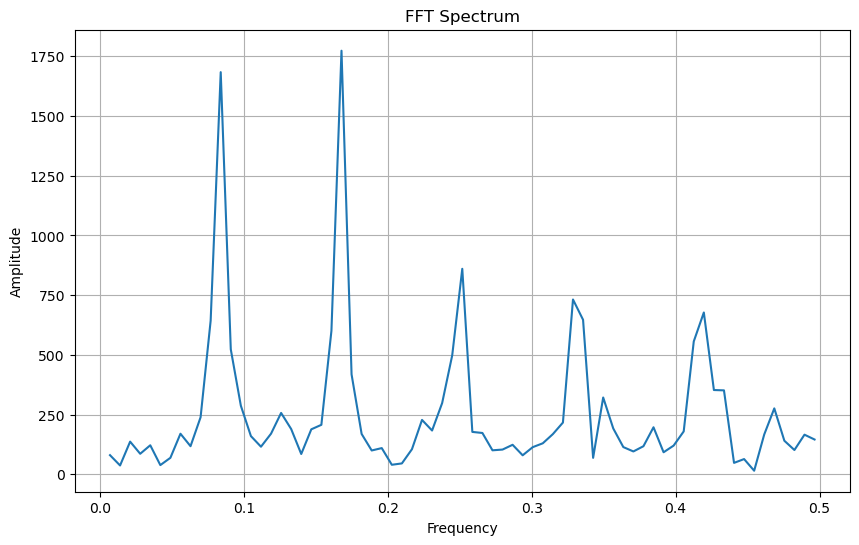

5.958333333333333

In [35]:
fft_find_seasonal(df2.Passengers, differencing = 1)

#### 2.2. Run a SARIMA model with m = 6 use both Step-wise and Full Grid Search

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.api import qqplot

def auto_sarima_split(df: pd.DataFrame, data_col: str, Ntest: int, freq='MS', s_test='kpss',
                      seasonal=True, m=12, stepwise=True, y_name='Number of Passengers',
                      plot=True, trace=False, plot_diagnostic=True):
    """
    Function to perform Auto SARIMA(p, d, q)(P, D, Q)[m] with train-test split, where Ntest is the number
    of steps for test. Outputs model summary, diagnostics (optional), and a plot of actual vs fitted vs forecast if plot=True.
    
    Parameters:
    - df: DataFrame containing the time series data
    - data_col: Column name of the time series data in the DataFrame
    - Ntest: Number of test periods to split from the data
    - s_test: Stationarity test to be used (e.g., 'kpss', 'adf')
    - seasonal: Boolean indicating whether to fit a seasonal ARIMA model
    - m: Number of periods in a seasonal cycle
    - stepwise: Boolean; if False, do full grid search
    - y_name: Label for the y-axis in the plot
    - plot: Boolean to indicate whether to plot the actual, fitted, and forecasted values
    - trace: Boolean to indicate whether to show detailed logs during model selection
    - plot_diagnostic: Boolean to indicate whether to plot the diagnostic plots (Residual, ACF, PACF, QQ-Plot)
    
    Outputs:
    - Model summary
    - Optional plot of actual, fitted, and forecasted values
    - Optional diagnostic plots for residual analysis
    - Returns the actual and forecasted values for further evaluation
    """
    
    # Set the frequency of the time series
    df.index.freq = freq

    # Split the data into train and test sets
    train = df.iloc[:-Ntest]
    test = df.iloc[-Ntest:]
    
    # Fit the Auto ARIMA model
    model = pm.auto_arima(train[data_col], 
                          trace=trace,            # Set whether to trace the model selection process
                          suppress_warnings=True,
                          test=s_test,            # Stationarity test (e.g., 'kpss', 'adf')
                          seasonal=seasonal, 
                          m=m, 
                          stepwise=stepwise,
                          max_p=15, max_q=10, max_order=25)

    if plot:
        # Extract the model orders
        order = model.order  # (p, d, q)
        seasonal_order = model.seasonal_order  # (P, D, Q, m)
        
        # Plot the actual values
        fig, ax = plt.subplots(figsize=(15, 7))
        ax.plot(df.index, df[data_col], label='Actual data', color='orange', alpha=0.5)

        # Get the differencing order `d` from the model
        d = model.order[1]  # Differencing order

        # Get in-sample fitted values (train predictions)
        train_prediction = model.predict_in_sample(start=d, end=len(train) - 1)

        # Plot fitted values for training data
        ax.plot(train.index[d:], train_prediction, label='Fitted values', color='green')

        # Make forecast for the test period
        test_forecast, confint = model.predict(n_periods=Ntest, return_conf_int=True)

        # Plot forecasted values for test period
        ax.plot(test.index, test_forecast, label='Forecast', color='blue')
        
        # Plot confidence interval
        ax.fill_between(test.index, confint[:, 0], confint[:, 1], color='grey', alpha=0.3)

        # Add plot labels and legend
        ax.legend(loc='best')

        # Update the title to include the model order and seasonal order
        ax.set_title(f'Auto SARIMA {order} x {seasonal_order} ({y_name})', color='darkred')
        ax.set_ylabel(y_name)
        ax.set_xlabel('Date')
        ax.grid(True, alpha=0.3)
        
        # Show the plot
        plt.show()

    # Output the model summary
    print(model.summary())
    
    if plot_diagnostic:
        # Perform diagnostic plots using statsmodels diagnostic tools
        residuals = model.resid()  # Get residuals from the model
        
        # Plot diagnostic figures for residuals
        fig, ax = plt.subplots(2, 2, figsize=(15, 10))

        # Plot residuals
        ax[0, 0].plot(residuals)
        ax[0, 0].set_title("Residuals")

        # Plot ACF
        plot_acf(residuals, ax=ax[0, 1], lags=40)
        ax[0, 1].set_title("ACF of Residuals")

        # Plot PACF
        plot_pacf(residuals, ax=ax[1, 0], lags=40)
        ax[1, 0].set_title("PACF of Residuals")

        # Plot QQ-plot
        qqplot(residuals, line='s', ax=ax[1, 1])
        ax[1, 1].set_title("QQ Plot of Residuals")

        plt.tight_layout()
        plt.show()
    
    # Adjust `actual_train` to match the length of `train_prediction`
    actual_train = train[data_col].iloc[d:]  # Start from index `d` to match `train_prediction`
    
    # Return actual train, train predictions, actual test values, and test forecasts for evaluation
    actual_test = test[data_col]
    return actual_train, train_prediction, actual_test, test_forecast

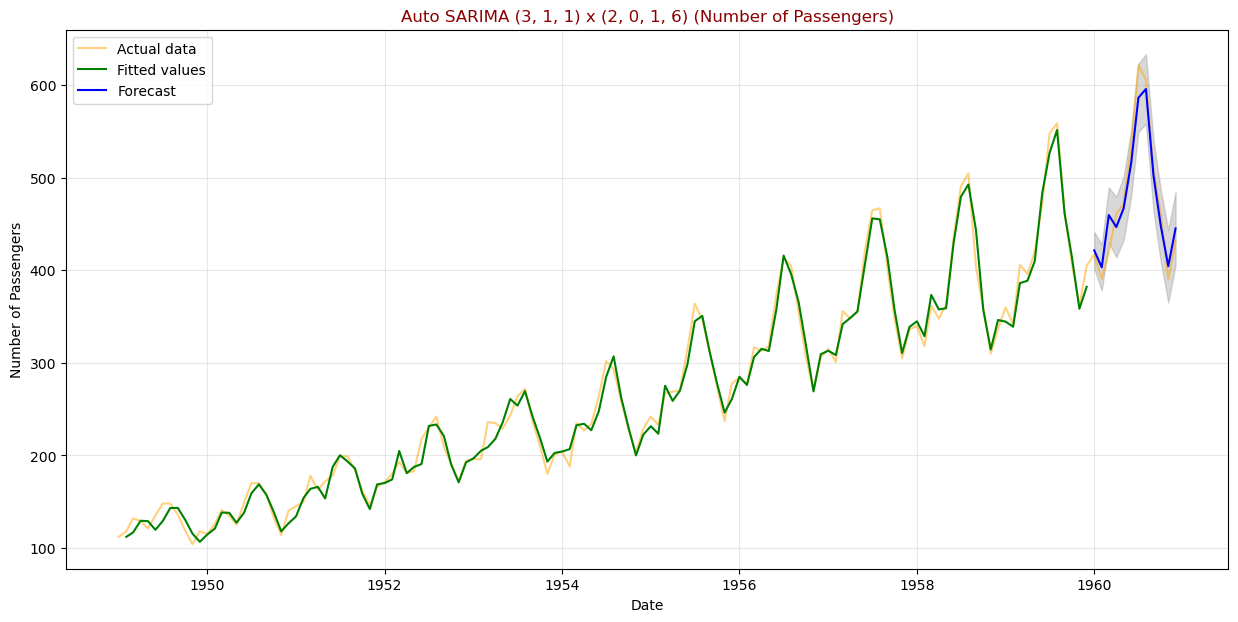

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  132
Model:             SARIMAX(3, 1, 1)x(2, 0, 1, 6)   Log Likelihood                -503.385
Date:                           Sun, 20 Oct 2024   AIC                           1022.770
Time:                                   01:13:02   BIC                           1045.772
Sample:                               01-01-1949   HQIC                          1032.117
                                    - 12-01-1959                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7311      0.104      7.041      0.000       0.528       0.935
ar.L2          0.2162      0.124      1.748

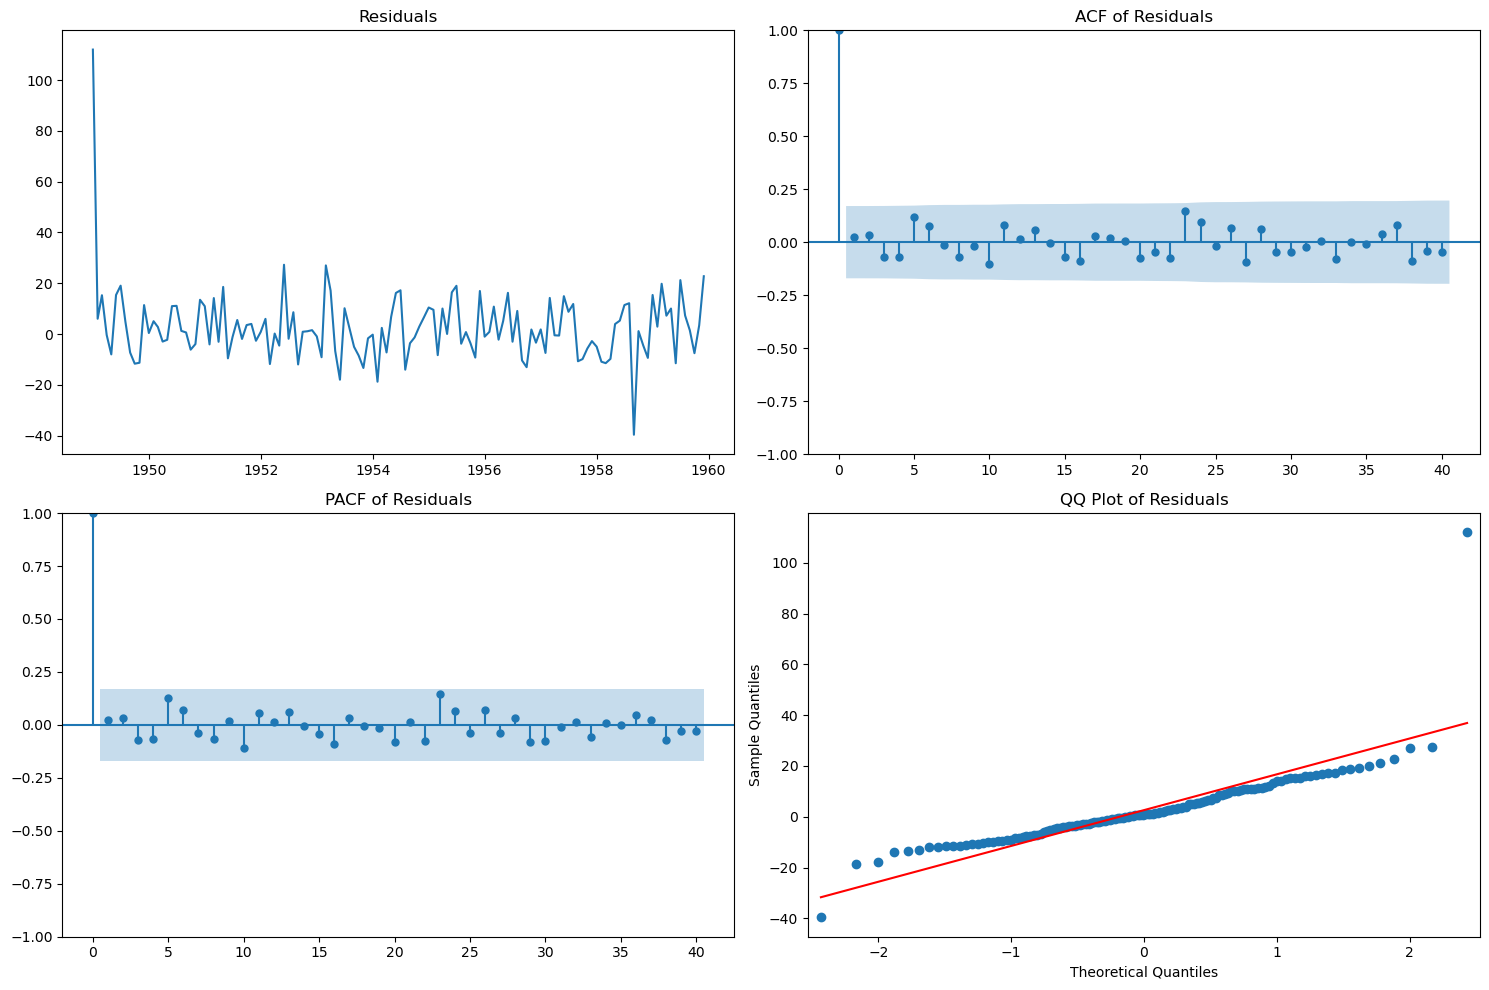

In [38]:
train_actual3, train_pred3, test_actual3, test_pred3 = auto_sarima_split(df2.dropna(), 'Passengers', 
                                                                            Ntest = 12,
                                                                            seasonal=True, m=6, 
                                                                            y_name='Number of Passengers',
                                                                        trace = False)
# Use m = 6
# Here the Auto SARIMA model will identify the optimal d so we don't need to apply differencing

* The best Auto SARIMA model using m = 12 is (3, 1, 1)(2, 0, 1)[6]
* Compare to ARIMA(12, 1, 0), both are similar in terms of AIC.
* Since 0.87 is significantly higher than the typical significance level (e.g., 0.05), we fail to reject the null hypothesis. This is a good sign because it suggests that `there is no significant autocorrelation left in the residuals` and that the model has successfully captured the main patterns in the data. Hence, we have address the problem of the ARIMA(12, 1, 0) model by extending it to the SARIMA version.

* <b>Try Full-Grid Search<b>

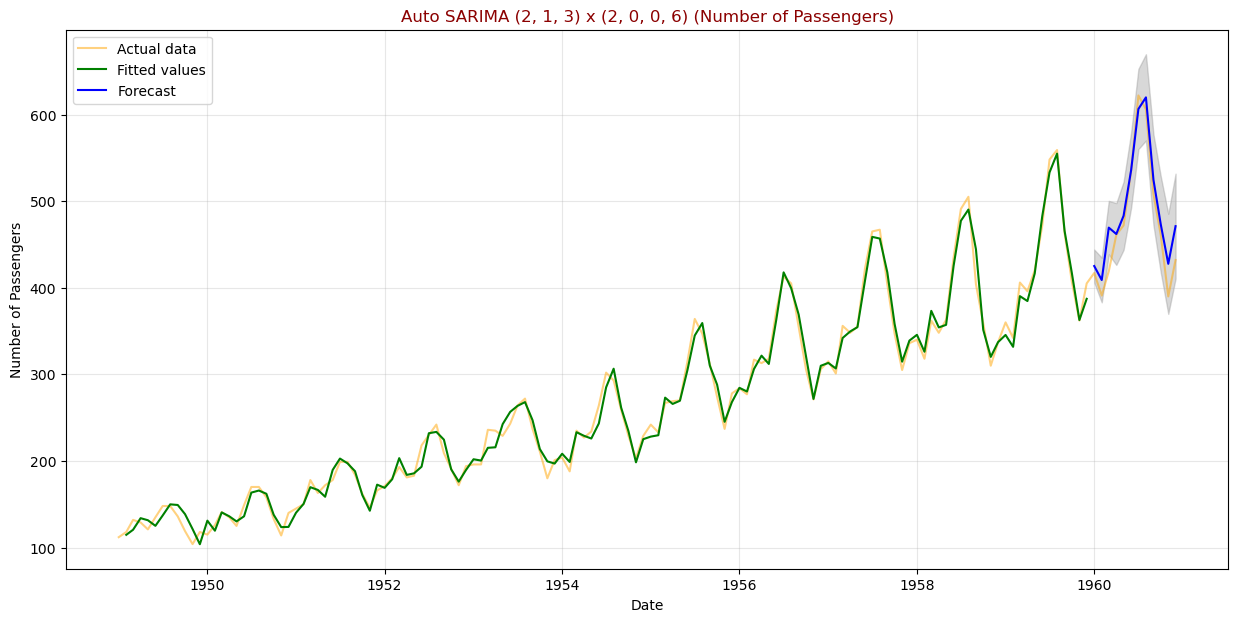

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(2, 1, 3)x(2, 0, [], 6)   Log Likelihood                -499.266
Date:                            Sun, 20 Oct 2024   AIC                           1016.533
Time:                                    01:14:44   BIC                           1042.410
Sample:                                01-01-1949   HQIC                          1027.048
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4152      2.461      0.169      0.866      -4.407       5.238
ar.L1         -1.8809      0.061   

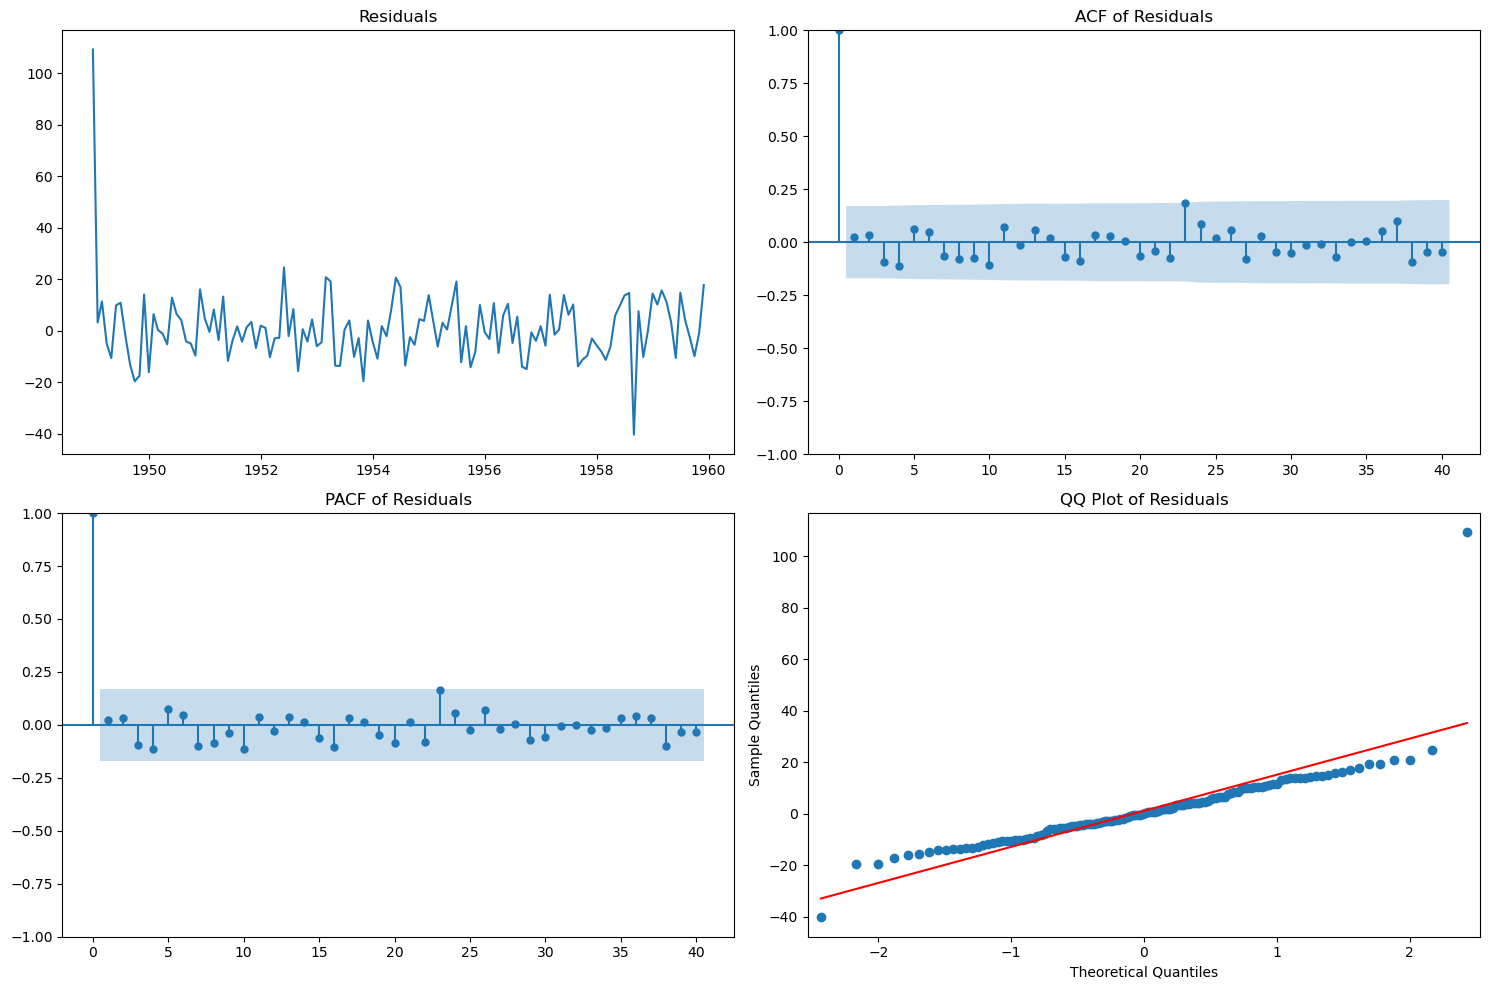

In [41]:
train_actual4, train_pred4, test_actual4, test_pred4 = auto_sarima_split(df2.dropna(), 'Passengers', 
                                                                            Ntest = 12,
                                                                            seasonal=True, m=6, 
                                                                             stepwise = False,
                                                                         trace = False,
                                                                            y_name='Number of Passengers')
# Use m = 6 with Full Grid Search

* The optimal model using Full Grid Search is SARIMA(2, 1, 3)(2, 0, 0)[6].
* Its AIC is slight lower than SARIMA(3, 1, 1)(2, 0, 1)[6].

In [43]:
# SARIMA(3, 1, 1)(2, 0, 1)[6]
print(
    evaluate_model(train_actual3, train_pred3))
print(
    evaluate_model(test_actual3, test_pred3)
)

{'MAE': 8.201088, 'MSE': 111.701638, 'RMSE': 10.5689, 'MAPE': 3.47329, 'R²': 0.990022}
{'MAE': 15.622097, 'MSE': 363.81513, 'RMSE': 19.073938, 'MAPE': 3.307145, 'R²': 0.934323}


In [44]:
# SARIMA(2, 1, 3)(2, 0, 0)[6].
print(
    evaluate_model(train_actual4, train_pred4))
print(
    evaluate_model(test_actual4, test_pred4)
)

{'MAE': 8.29543, 'MSE': 108.084097, 'RMSE': 10.39635, 'MAPE': 3.626544, 'R²': 0.990345}
{'MAE': 18.687263, 'MSE': 571.152315, 'RMSE': 23.898793, 'MAPE': 4.222463, 'R²': 0.896894}


* The in-sample prediction of both are equivalent.
* For out-of-sample prediction, SARIMA(3, 1, 1)(2, 0, 1)[6] indicates a better result.

#### 2.3. Try Auto SARIMA with no seasonal factor and Full Grid Search

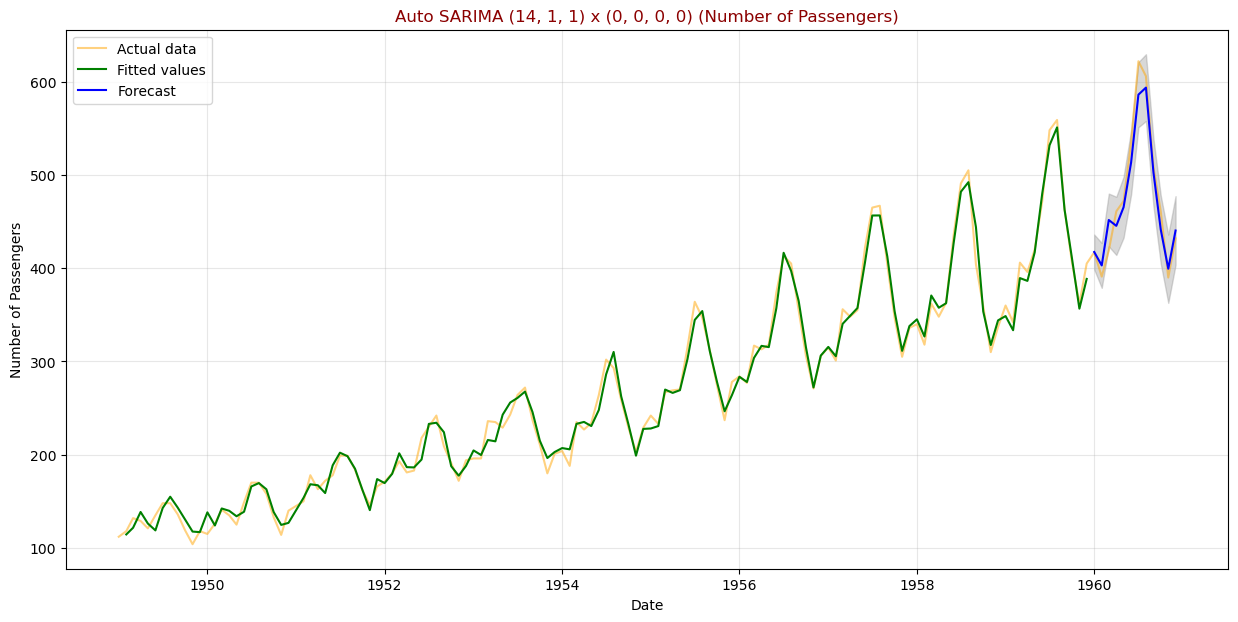

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  132
Model:              SARIMAX(14, 1, 1)   Log Likelihood                -492.521
Date:                Sun, 20 Oct 2024   AIC                           1019.042
Time:                        01:15:48   BIC                           1067.920
Sample:                    01-01-1949   HQIC                          1038.903
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.0337      2.976      1.692      0.091      -0.799      10.866
ar.L1         -0.3796      0.567     -0.670      0.503      -1.491       0.731
ar.L2         -0.0819      0.193     -0.425      0.6

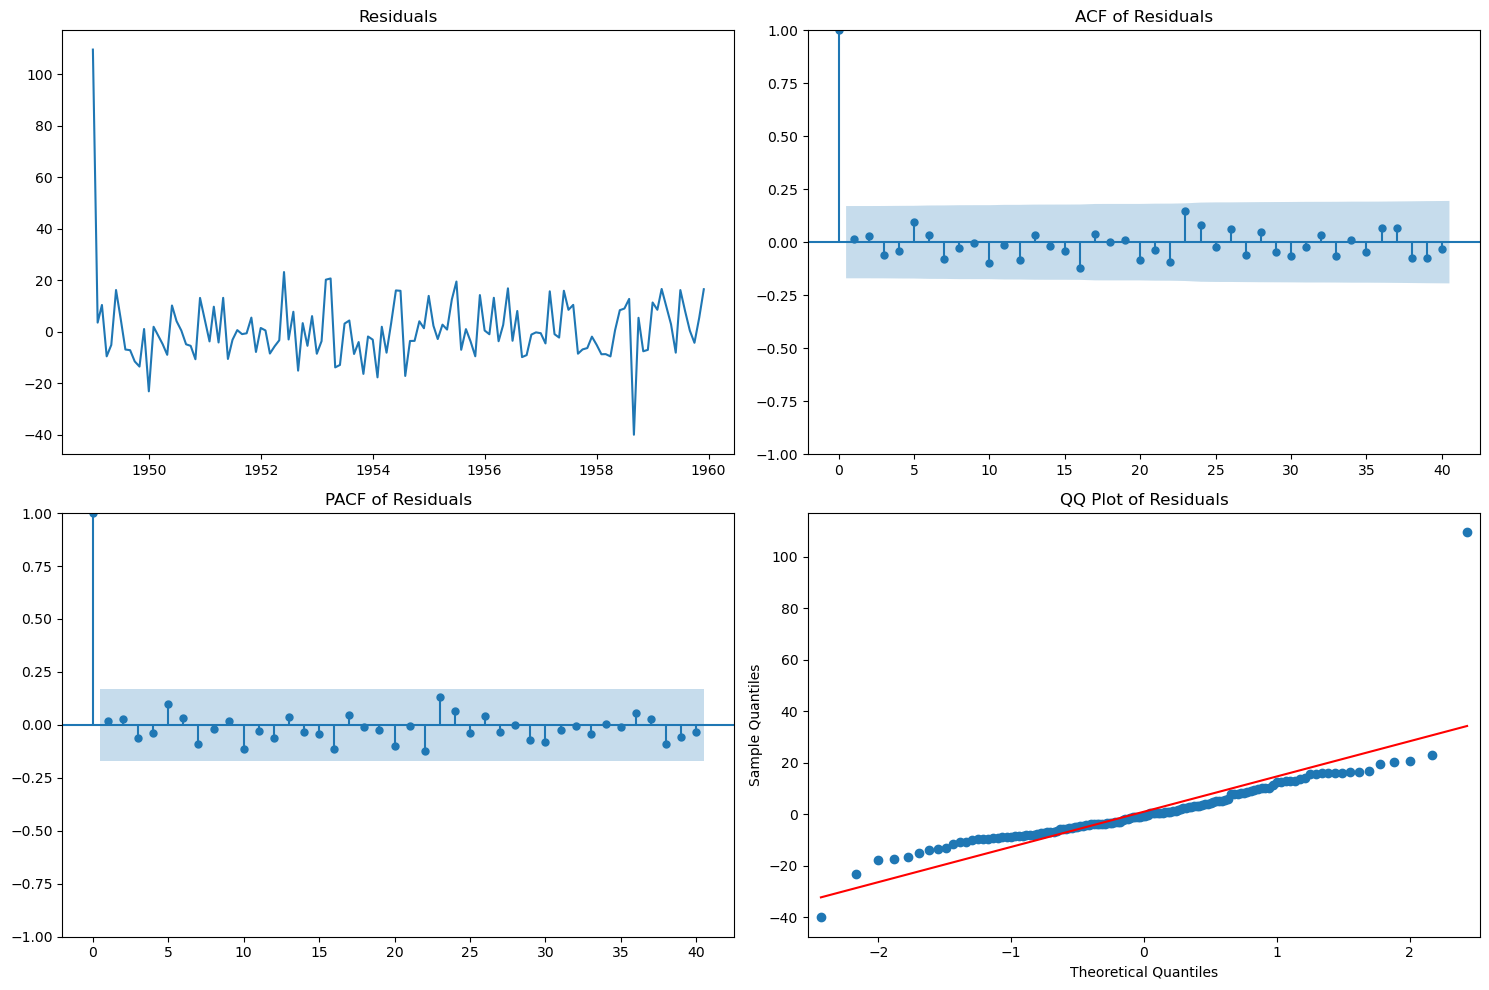

In [47]:
train_actual5, train_pred5, test_actual5, test_pred5 = auto_sarima_split(df2.dropna(), 'Passengers', 
                                                                            Ntest = 12,
                                                                            seasonal=False, 
                                                                             stepwise = False,
                                                                         trace = False,
                                                                            y_name='Number of Passengers')

In [48]:
# ARIMA(14, 1, 1)
print(
    evaluate_model(train_actual5, train_pred5))
print(
    evaluate_model(test_actual5, test_pred5)
)

{'MAE': 7.746827, 'MSE': 98.259867, 'RMSE': 9.912612, 'MAPE': 3.385423, 'R²': 0.991223}
{'MAE': 14.969064, 'MSE': 330.736625, 'RMSE': 18.186166, 'MAPE': 3.100583, 'R²': 0.940295}


* By increase the AR order, the non-seasonal ARIMA model passes the Ljung-Box Test. This means that the order 12 is not sufficient.

#### 2.4.  Let's try Time Series Decomposition to see if seasonality is signficant.

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Function to decompose the series and plot the components
def decompose_series(data, model='additive', period=None):
    """
    Decompose a time series into trend, seasonal, and residual components and plot the results.
    
    Args:
        data (pd.Series): Time series data.
        model (str): 'additive' or 'multiplicative'.
        period (int): Number of observations per cycle (e.g., 12 for monthly data with yearly seasonality).
    
    Returns:
        decomposition (DecomposeResult): Decomposed components of the series.
    """
    # Decompose the series
    decomposition = seasonal_decompose(data, model=model, period=period)

    # Plot the decomposed components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(f'{model.capitalize()} Decomposition of the Time Series')

    # Plot original series
    ax1.plot(data, label='Original', color='blue')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Observed')

    # Plot trend component
    ax2.plot(decomposition.trend, label='Trend', color='orange')
    ax2.legend(loc='upper left')
    ax2.set_ylabel('Trend')

    # Plot seasonal component
    ax3.plot(decomposition.seasonal, label='Seasonal', color='green')
    ax3.legend(loc='upper left')
    ax3.set_ylabel('Seasonal')

    # Plot residual component
    ax4.plot(decomposition.resid, label='Residual', color='red')
    ax4.legend(loc='upper left')
    ax4.set_ylabel('Residual')

    plt.show()
    
    return decomposition

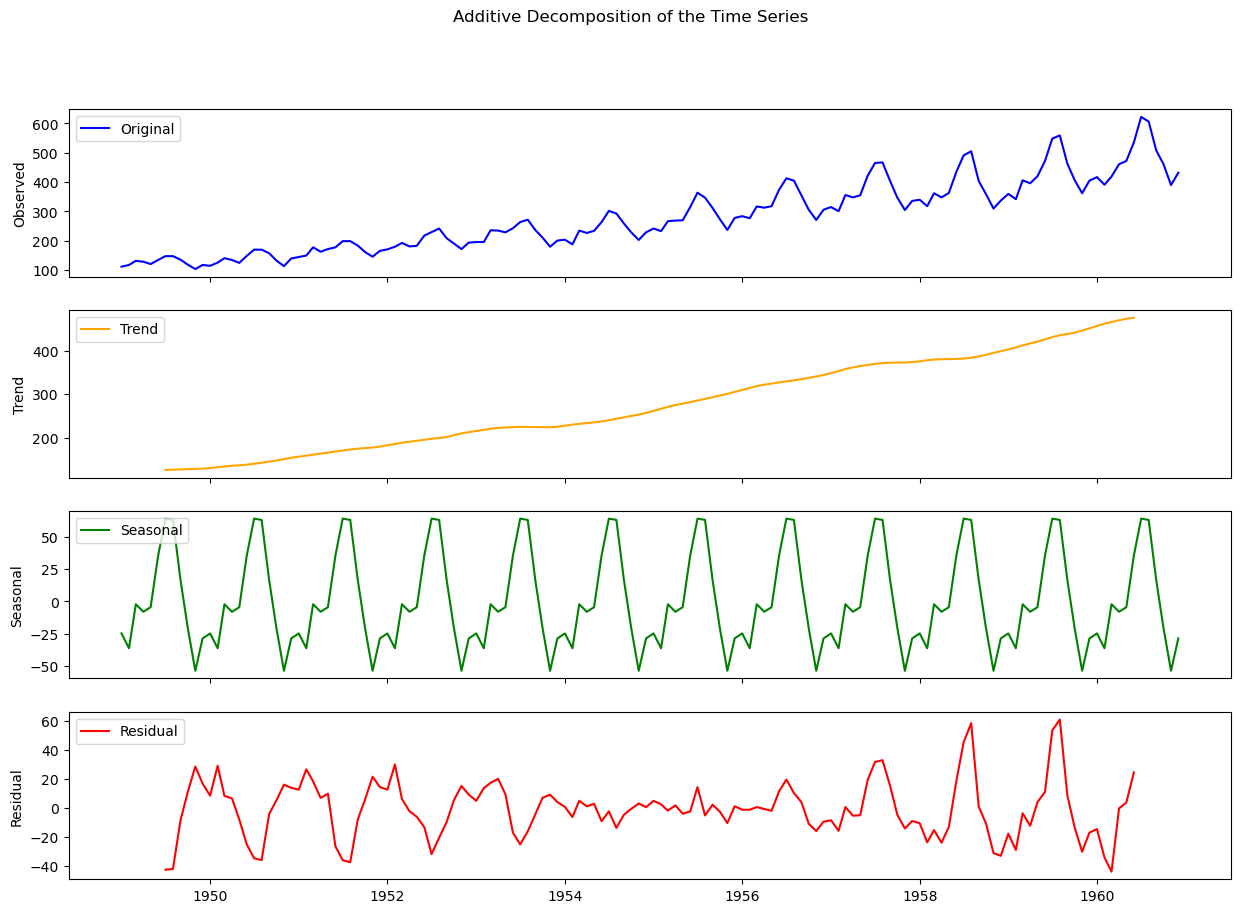

In [52]:
decompose_series(df2.Passengers)

### <b>3. Overall<b>

* What is your opinion?
* <b>I would prefer the SARIMA(3, 1, 1)(2, 0, 1)[6] model at this point.<b>

* Although the real practice should be more thorough, by these examples, we can see that:
1) By applying fundamental techniques of Stationarity Test, ACF, PACF plot, we can still choose a decent model compared to the Auto processes.
2) Whether to include seasonaility may require domain knowledge (economic fundamentals and intuition).
3) More practice can be done by comparing these to the Naive forecast model.
4) More practice can be implemented by applying more sophisticated techniques.